In [71]:
import pandas as pd
import numpy as np
import tqdm
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from sklearn.externals import joblib
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import warnings 

%matplotlib inline

In [72]:
data = pd.read_csv('da26521-0003.tsv', sep='\t', header=0)

/home/peter/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (95,96,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
def replace_missing(x):
    
    if len(str(x)) == 1 and x in [8, 5, 9]:
            return np.nan
        
    if len(str(x)) == 2 and x in [88, 95, 98, 99, 97]:
            return np.nan
        
    if len(str(x)) == 3 and x in [888, 995, 998, 999, 98.0]:
            return np.nan
        
    if len(str(x)) == 4 and x in [88.8, 99.5, 99.8, 8888, 9995, 9998, 9999]:
            return np.nan
        
    if len(str(x)) == 5 and x in [888.8, 999.5, 999.8, 88888, 99995, 99998, 99999]:
            return np.nan
        
    if len(str(x)) == 6 and x in [8888.8, 9999.5, 9999.8]:
            return np.nan    
    
    else:
        return x

In [74]:
data = data.applymap(lambda x: replace_missing(x)).copy()

In [78]:
def list_of_absent_data_columns(data, ratio=0.2):
    """returns list of columns whose missing values make up \
    more than a set ratio (default is half) of the data"""
    variables_list = list(data.columns)
    missing_list = []
    for variable in variables_list:
        missing_ratio = sum(data[variable].isna()) / len(data)
        if missing_ratio > ratio:
            missing_list.append(variable)
    return missing_list

In [79]:
absent_columns = list_of_absent_data_columns(data)

In [80]:
data.drop(columns=absent_columns, inplace=True)

In [81]:
def missing_vis(data):
    """Returns 4 graphics: bar chart, distributions, heatmap \
    (of correlation between nulls), and dendogram"""
    msno.bar(data);
    msno.matrix(data);
    msno.heatmap(data);
    msno.dendrogram(data);


In [82]:
data.shape

(289009, 34)

In [83]:
singular_variables = []
for col in data.columns:
#     print(col, len(set(prison_data[col])))
    if data[col].nunique() == 1:
        singular_variables.append(col)
print(singular_variables)


['V1', 'V2', 'V3', 'V5', 'V54', 'V95']


In [84]:
data.drop(columns = singular_variables, inplace=True)

In [85]:
data.columns

Index(['V4', 'V8', 'V9', 'V10', 'V15', 'V24', 'V25', 'V26', 'V32', 'V33',
       'V34', 'V46', 'V48', 'V51', 'V55', 'V56', 'V57', 'V58', 'V59', 'V62',
       'V67', 'V70', 'V71', 'V94', 'V96', 'V97', 'V98', 'V99'],
      dtype='object')

In [86]:
data.head()

,V4,V8,V9,V10,V15,V24,V25,V26,V32,V33,...,V59,V62,V67,V70,V71,V94,V96,V97,V98,V99
0,1.0,1949.0,1.0,2.0,2002.0,28.1,0.0,410.0,410.0,120.0,...,55.6,14.2,12.0,2.0,0,1.0,000809,999998,999998,000809
1,2.0,1948.0,1.0,2.0,2000.0,8.8,0.0,190.0,540.0,180.0,...,55.6,44.8,6.1,2.0,2,1.0,000103,000490,999998,000490
2,3.0,1943.0,1.0,2.0,2000.0,10.4,0.0,270.0,270.0,180.0,...,61.1,41.4,7.1,2.0,0,1.0,000212,999998,999998,000212
3,4.0,1948.0,1.0,2.0,1984.0,1.6,0.0,410.0,370.0,240.0,...,55.9,102.0,136.3,2.0,2,1.0,000809,000808,000252,000808
4,NaN,1950.0,1.0,2.0,NaN,0.0,247.7,10.0,10.0,99999.6,...,53.7,NaN,179.1,2.0,2,1.0,000003,000105,999998,000003


In [87]:
data.shape

(289009, 28)

In [92]:
data = data.dropna()

In [93]:
data_clean = data[data['V55'] != 10].copy()

In [94]:
data_clean['outcome'] = data_clean['V55'].map(lambda x: 1 if x == 1 else 0)

In [95]:
data_clean['outcome'].value_counts()

1    80565
0    79714
Name: outcome, dtype: int64

In [96]:
data_clean.drop(columns='V55', inplace=True)

In [97]:
data_clean.drop(columns=['V96', 'V97', 'V98', 'V99'], inplace=True)

In [98]:
data_clean.columns

Index(['V4', 'V8', 'V9', 'V10', 'V15', 'V24', 'V25', 'V26', 'V32', 'V33',
       'V34', 'V46', 'V48', 'V51', 'V56', 'V57', 'V58', 'V59', 'V62', 'V67',
       'V70', 'V71', 'V94', 'outcome'],
      dtype='object')

In [99]:
data_clean.shape

(160279, 24)

In [100]:
variable_names = {'V4': 'case_id',
                  'V8': 'birth_year',
                  'V9': 'sex',
                  'V10': 'race',
                  'V15': 'admission_year',
                  'V24': 'prior_jail_time',
                  'V25': 'prior_prison_time',
                  'V26': 'offense_1',
                  'V32': 'offense_longest_sentence',
                  'V33': 'length_longest_sentence',
                  'V34': 'total_max_sentence_length',
                  'V46': 'year_prison_release',
                  'V48': 'custody_agency_1',
                  'V51': 'release_type',
                  'V56': 'release_supervision_status',
                  'V57': 'age_admission',
                  'V58': 'age_prison_release',
                  'V59': 'age_parole_release',
                  'V62': 'time_served_current_admission',
                  'V67': 'time_served_parole',
                  'V70': 'total_max_sentence_indicator',
                  'V71': 'number_of_offenses_indicator',
                  'V94': 'state'}
variable_categories = {'key': ['case_id'],
                       'datetime': ['birth_year', 'admission_year', 'year_prison_release'],
                       'categorical': ['sex', 'race', 'offense_1', 'offense_longest_sentence', 'custody_agency_1',
                                       'release_type', 'release_supervision_status', 'number_of_offenses_indicator',
                                       'state'],
                       'numeric': ['prior_jail_time', 'prior_prison_time', 'age_admission', 'age_parole_release',
                                   'time_served_current_admission', 'time_served_parole'],
                       'mixed_numeric': ['length_longest_sentence', 'total_max_sentence_length',
                                         'total_max_sentence_indicator']}

In [101]:
descriptive_columns = list(variable_names.values())
descriptive_columns.append('outcome')
data_clean.columns = descriptive_columns
data_clean = pd.get_dummies(data_clean, columns=variable_categories['categorical'], 
                            drop_first=True)

In [102]:
data_clean.drop(columns=['race_2.0', 'race_3.0', 'race_4.0', 'race_6.0', 'sex_2.0'], inplace=True)

## Random Forest Model

In [103]:
X = data_clean.drop(columns='outcome')
y = data_clean['outcome']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [105]:
# yellowbrick.ClassBalance().fit(y_train);

### Random Forest Classifier Training

#### Grid Search for Params

In [110]:
# Set parameters for GridSearchCV to investigate

params = {
    'max_features' : ['auto', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [150],
    'max_depth' : [1, 10, 100, 1000, None]
}

In [111]:
# Define GridSearchCV Object and Parameters

search = GridSearchCV(estimator=RandomForestClassifier(),
                     scoring='accuracy',
                     param_grid=params,
                     cv=5,
                     return_train_score=True,
                     verbose=True,
                     n_jobs=-1)

In [112]:
# Run the GridSearchCV

warnings.simplefilter('ignore')

# search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'criterion': ['gini', 'entropy'], 'n_estimators': [150], 'max_depth': [1, 10, 100, 1000, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [114]:
# Save GridSearchCV results

filename = 'grid_search_rf.sav'
joblib.dump(search, filename)

['grid_search_rf.sav']

In [183]:
# Find best parameters to use in model 

search = joblib.load('grid_search_rf.sav')
print(search.best_params_, search.best_score_)

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 150} 0.8929447878278665


#### Random Forest Model

In [184]:
# Set RandomForest model based on GridSearchCV results

rfc = RandomForestClassifier(criterion='entropy', max_depth=100, max_features='auto', n_estimators=150, n_jobs=-1)

In [185]:
# Fit model

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [186]:
# Get train predictions from model

y_train_pred = rfc.predict(X_train)

In [187]:
# Analyze results via confustion matrix

confusion_matrix(y_train, y_train_pred)

array([[59696,     0],
       [    0, 60513]])

In [188]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59696
           1       1.00      1.00      1.00     60513

   micro avg       1.00      1.00      1.00    120209
   macro avg       1.00      1.00      1.00    120209
weighted avg       1.00      1.00      1.00    120209



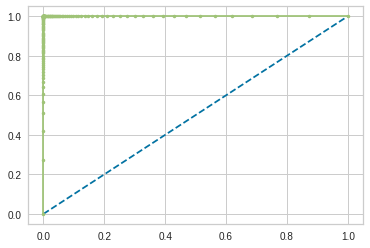

In [220]:
# Graph ROC curve for model

probs_train = rfc.predict_proba(X_train)[:,1]

fpr, tpr, thresholds = roc_curve(y_train, probs_train)
# Plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# Plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# Show the plot
plt.show()

### Random Forest Classifier Testing

In [192]:
# Get test results

y_test_pred = rfc.predict(X_test)

In [193]:
# Analyze results via confustion matrix

confusion_matrix(y_test, y_test_pred)

array([[18557,  1461],
       [ 2762, 17290]])

In [194]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     20018
           1       0.92      0.86      0.89     20052

   micro avg       0.89      0.89      0.89     40070
   macro avg       0.90      0.89      0.89     40070
weighted avg       0.90      0.89      0.89     40070



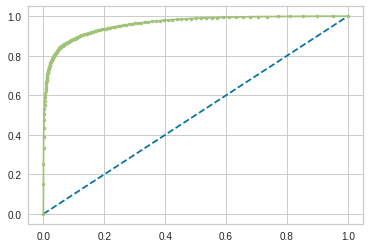

In [221]:
# Graph ROC curve for model

probs_test = rfc.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs_test)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

### Bias Analysis

#### Gender Bias

##### False Positives

In [224]:
# Generate Dataframe with results and original dataset

preds = pd.concat([y_test, pd.Series(y_test_pred, name='pred', index=y_test.index), X_test], axis=1, ignore_index=False)

preds = pd.merge(preds, data[['V9', 'V10']], left_index=True, right_index=True)

In [258]:
# Calculate sex-based percentage of false positives

sex_false_pos = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V9']

men_false_pos = sum(sex_false_pos == 1)/sum(data['V9'] == 1)

women_false_pos = sum(sex_false_pos == 2)/sum(data['V9'] == 2)

Text(0.5, 1.0, 'False Positive')

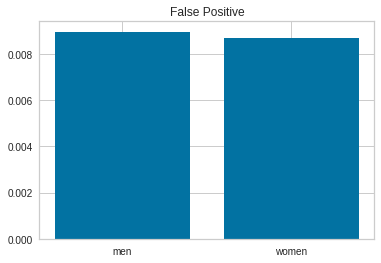

In [259]:
plt.bar(x=['men', 'women'], height=[men_false_pos, women_false_pos])
plt.title('False Positive')

##### False Negatives

In [269]:
# Calculate sex-based percentage of false negatives

sex_false_neg = preds.loc[(preds['outcome'] == 1) & (preds['pred'] == 0)]['V9']

men_false_neg = sum(sex_false_neg == 1)/sum(data['V9'] == 1)

women_false_neg = sum(sex_false_neg == 2)/sum(data['V9'] == 2)

Text(0.5, 1.0, 'False Negative')

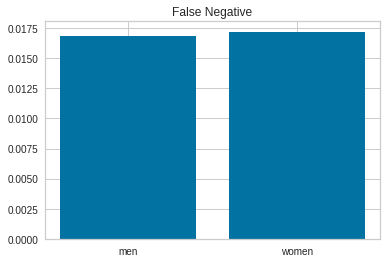

In [270]:
plt.bar(x=['men', 'women'], height=[men_false_neg, women_false_neg])
plt.title('False Negative')

#### Racial Bias

In [274]:
racial_false_pos = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V10']

white_false_pos = sum(racial_false_pos == 1)/sum(data['V10'] == 1)

black_false_pos = sum(racial_false_pos == 2)/sum(data['V10'] == 2)

americanindian_false_pos = sum(racial_false_pos == 3)/sum(data['V10'] == 3)

asian_false_pos = sum(racial_false_pos == 4)/sum(data['V10'] == 4)

other_false_pos = sum(racial_false_pos == 6)/sum(data['V10'] == 6)

Text(0.5, 1.0, 'False Positive')

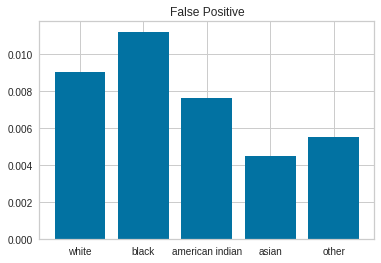

In [275]:
plt.bar(x=['white', 'black', 'american indian', 'asian', 'other'], 
        height=[white_false_pos,
               black_false_pos,
               americanindian_false_pos,
               asian_false_pos,
               other_false_pos])
plt.title('False Positive')

In [276]:
racial_false_neg = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V10']

white_false_neg = sum(racial_false_pos == 1)/sum(data['V10'] == 1)

black_false_neg = sum(racial_false_pos == 2)/sum(data['V10'] == 2)

americanindian_false_neg = sum(racial_false_pos == 3)/sum(data['V10'] == 3)

asian_false_neg = sum(racial_false_pos == 4)/sum(data['V10'] == 4)

other_false_neg = sum(racial_false_pos == 6)/sum(data['V10'] == 6)

<BarContainer object of 5 artists>

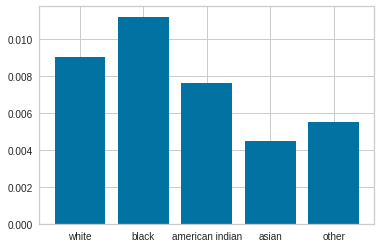

In [277]:
plt.bar(x=['white', 'black', 'american indian', 'asian', 'other'], 
        height=[white_false_neg,
               black_false_neg,
               americanindian_false_neg,
               asian_false_neg,
               other_false_neg])

### Model Visualizations

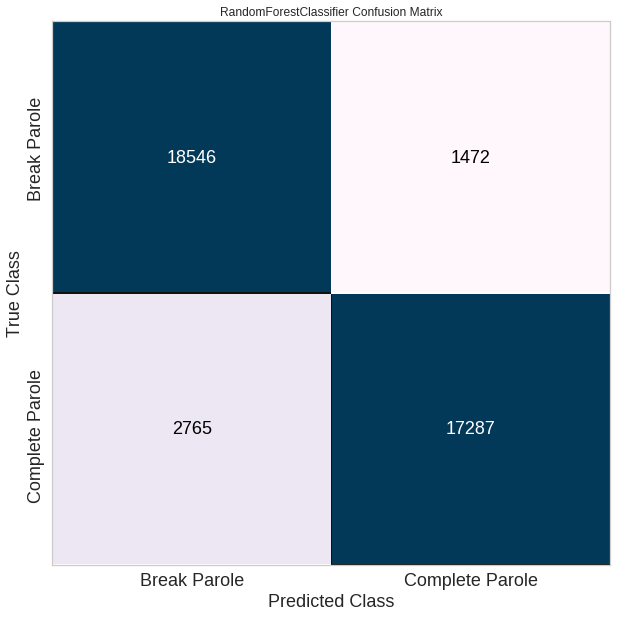

In [167]:
# Plot 

plt.figure(figsize=(10,10))
viz = ConfusionMatrix(RandomForestClassifier(n_estimators=150, oob_score=True, criterion='entropy', max_depth=100, n_jobs=-1), cmap ='PuBu', fontsize=18)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
plt.xlabel('Predicted Class', fontsize=18)
plt.ylabel('Actual Class', fontsize=18)
plt.xticks(ticks = [0.5, 1.5], labels=['Break Parole', 'Complete Parole'], rotation=0)
plt.yticks(ticks = [0.7, 1.7], labels=['Complete Parole', 'Break Parole'], rotation=90)
viz.poof()